# 05Tools: Model Monitoring
## IN ACTIVE DEVELOPMENT - NOT COMPLETE

Model training results in a model that reflects a translations of features to predictions.  Without further training or re-training, this becomes dependent on the training data.  Monitoring is essential for understanding risk, or trust, in a model to do the task it was created for.  There are multiple aspects that may be desired for monitoring:

- Features
    - At Prediction time
        - features shift from train time: training-serving **skew**
        - features change over time: prediction *drift**
        - feature attributions
            - From model explainability
        - Predictions themselves
        - considerations:
            - online predictions
            - batch predictions
            - edge preditions
    - At data time
        - values over time - feature store
        - a change in feature stability over time may impact currently deployed models
        - changes in features may change their consideration for future model development

This notebook will setup model monitoring for a Vertex AI Endpoint hosted model.  Model Monitoring will be setup for skew and drift with thresholds set for all features and feature attributions (explanations):
- numerical features difference is calculated with [Jensen-Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence)
- categorical features difference is calculated with [L-infinity distance](https://en.wikipedia.org/wiki/Chebyshev_distance)

**Prerequisites:**
-  At least 1 of the notebooks in this series [05, 05a-05i]
   
**Resources:**
- [Python Client for Vertex AI](https://googleapis.dev/python/aiplatform/latest/aiplatform.html)
- [Model Monitoring Documentation](https://cloud.google.com/vertex-ai/docs/model-monitoring/overview)
- [Blog: Monitor Models with Vertex AI](https://cloud.google.com/blog/topics/developers-practitioners/monitor-models-training-serving-skew-vertex-ai)

### Conceptual Flow & Workflow
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/05tools_monitor_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/05tools_monitor_console.png" width="45%">
</p>

---
## Setup

inputs:

In [47]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [48]:
REGION = 'us-central1'
EXPERIMENT = 'monitoring'
SERIES = '05'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'fraud'
BQ_TABLE = 'fraud_prepped'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [166]:
from google.cloud import aiplatform

from google.cloud import bigquery
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import json
import numpy as np
import matplotlib.pyplot as plt

clients:

In [50]:
aiplatform.init(project = PROJECT_ID, location = REGION)
bq = bigquery.Client()

parameters:

In [51]:
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{SERIES}/{EXPERIMENT}"

---
## Endpoint
This project already has a model serving online predictions at a Vertex AI Endpoint.  This section will use the endpoint to retrieve the deployed model and get its information to use for batch prediction methods in this notebook.

### Get Endpoint

[Endpoint Properties and Methods](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint):

```python
endpoint
endpoint.display_name
endpoint.resource_name
endpoint.traffic_split
endpoint.list_models()
```

In [52]:
endpoints = aiplatform.Endpoint.list(filter = f"labels.series={SERIES}")
endpoint = endpoints[0]

In [53]:
print(f'Review the Endpoint in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/endpoints/{endpoint.name}?project={PROJECT_ID}')

Review the Endpoint in the Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/endpoints/1961322035766362112?project=statmike-mlops-349915


### Get Model at Endpoint
Using the model on the endpoint for the current series:

In [54]:
endpoint

resource name: projects/1026793852137/locations/us-central1/endpoints/1961322035766362112

In [55]:
#endpoint.list_models()[0]

In [56]:
model = aiplatform.Model(
    model_name = endpoint.list_models()[0].model+f'@{endpoint.list_models()[0].model_version_id}'
)

### Review Model Information

In [57]:
model.display_name

'05_05h'

In [58]:
model.resource_name

'projects/1026793852137/locations/us-central1/models/model_05_05h'

In [59]:
model.version_id

'1'

In [60]:
model.version_description

'run-20220927230247-6'

In [61]:
model.versioned_resource_name

'projects/1026793852137/locations/us-central1/models/model_05_05h@1'

In [62]:
model.supported_input_storage_formats

['jsonl', 'bigquery', 'csv', 'tf-record', 'tf-record-gzip', 'file-list']

In [63]:
model.name

'model_05_05h'

In [64]:
model.uri

'gs://statmike-mlops-349915/05/05h/models/20220927230247/6/model'

In [65]:
print(f'Review the model in the Vertex AI Model Registry:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{model.name}/versions/{model.version_id}/properties?project={PROJECT_ID}')

Review the model in the Vertex AI Model Registry:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/model_05_05h/versions/1/properties?project=statmike-mlops-349915


---
### Retrieve Records For Prediction

In [66]:
n = 1000
pred = bq.query(query = f"SELECT * FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE} WHERE splits='TEST' LIMIT {n}").to_dataframe()

In [67]:
pred.head(4)

Time        V1        V2        V3        V4        V5        V6  \
0   35337  1.092844 -0.013230  1.359829  2.731537 -0.707357  0.873837   
1   60481  1.238973  0.035226  0.063003  0.641406 -0.260893 -0.580097   
2  139587  1.870539  0.211079  0.224457  3.889486 -0.380177  0.249799   
3  162908 -3.368339 -1.980442  0.153645 -0.159795  3.847169 -3.516873   

         V7        V8        V9  ...       V23       V24       V25       V26  \
0 -0.796130  0.437707  0.396770  ... -0.167647  0.027557  0.592115  0.219695   
1  0.049938 -0.034733  0.405932  ... -0.057718  0.104983  0.537987  0.589563   
2 -0.577133  0.179189 -0.120462  ...  0.180776 -0.060226 -0.228979  0.080827   
3 -1.209398 -0.292122  0.760543  ... -1.171627  0.214333 -0.159652 -0.060883   

        V27       V28  Amount  Class                        transaction_id  \
0  0.036970  0.010984     0.0      0  a1b10547-d270-48c0-b902-7a0f735dadc7   
1 -0.046207 -0.006212     0.0      0  814c62c8-ade4-47d5-bf83-313b0aafdee5   
2  0.009868 -0.036997     0.0      0  d08a1bfa-85c5-4f1b-9537-1c5a93e6afd0   
3  1.294977  0.120503     0.0      0  802f3307-8e5a-4475-b795-5d5d8d7d0120   

   splits  
0    TEST  
1    TEST  
2    TEST  
3    TEST  

[4 rows x 33 columns]

Remove columns not included as features in the model:

In [68]:
newobs = pred[pred.columns[~pred.columns.isin(VAR_OMIT.split()+[VAR_TARGET, 'splits'])]].to_dict(orient='records')
#newobs[0]

In [69]:
len(newobs)

1000

---
### Predictions

For more ways to request predictions from a Vertex AI Endpoint see the [05Tools - Prediction - Online.ipynb](./05Tools%20-%20Prediction%20-%20Online.ipynb) notebook.

#### Get Prediction: Python Client

In [70]:
instances = [json_format.ParseDict(newobs[0], Value())]

In [71]:
prediction = endpoint.predict(instances = instances)
prediction

Prediction(predictions=[[0.999359429, 0.000640570885]], deployed_model_id='6805735083375329280', model_version_id='1', model_resource_name='projects/1026793852137/locations/us-central1/models/model_05_05h', explanations=None)

In [72]:
prediction.predictions[0]

[0.999359429, 0.000640570885]

In [73]:
np.argmax(prediction.predictions[0])

0

### Explanations

If the endpoint is hosting a model with traffic that is also enable for feature-based explanations using the `explanationSpec` then also enable monitoring of feature attributions.  To see how to enable a custom model for feature-based explanations, and to enable them for the model on this endpoint, review the [05Tools - Explainability - Feature-Based](./05Tools%20-%20Explainability%20-%20Feature-Based.ipynb) notebook.

In [74]:
endpoint.traffic_split

{'6805735083375329280': 100}

In [75]:
explanation_models = [m for m in endpoint.list_models() if endpoint.traffic_split[m.id] > 0.0 and m.explanation_spec]

prediction =  [0.999359429, 0.000640570885]
attributions ...
baseline output: 0.9998088479042053
instance output: 0.9993594288825989
output_index: [0]
output_name: prediction_layer
approximation error: 0.03523130529534055


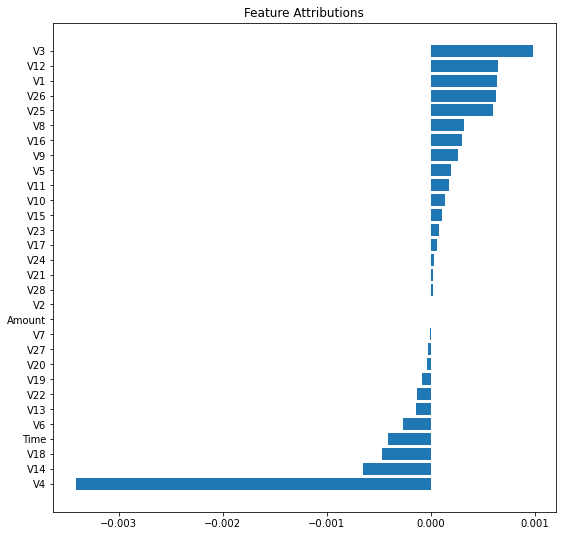

In [83]:
if explanation_models:
    explanation = endpoint.explain(instances = instances)
    print('prediction = ', explanation.predictions[0])
    print("attributions ...")
    print("baseline output:",explanation.explanations[0].attributions[0].baseline_output_value)
    print("instance output:",explanation.explanations[0].attributions[0].instance_output_value)
    print("output_index:",explanation.explanations[0].attributions[0].output_index)
    print("output_name:",explanation.explanations[0].attributions[0].output_name)
    print("approximation error:",explanation.explanations[0].attributions[0].approximation_error)
    
    features = []
    scores = []
    for k in explanation.explanations[0].attributions[0].feature_attributions:
        features.append(k)
        scores.append(explanation.explanations[0].attributions[0].feature_attributions[k])
    features = [x for _, x in sorted(zip(scores, features))]
    scores = sorted(scores)
    fig, ax = plt.subplots()
    fig.set_size_inches(9, 9)
    ax.barh(features, scores)
    plt.title('Feature Attributions')
    fig.show()

---
## Monitoring

### Training Data

In [139]:
query = f"""
CREATE OR REPLACE VIEW `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_trainingView` AS
    SELECT * EXCEPT(splits, {VAR_OMIT.replace(' ',',')})
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TRAIN'
"""
createView = bq.query(query)
createView.result()

### Sampling Strategy

In [140]:
sampling_config = aiplatform.model_monitoring.RandomSampleConfig(
    sample_rate = 1.0
)

### Schedule

In [141]:
schedule_config = aiplatform.model_monitoring.ScheduleConfig(
    monitor_interval = 1 #  min is one hour = 1
)

### Alerts

In [142]:
alerting_config = aiplatform.model_monitoring.EmailAlertConfig(
    user_emails = ['statmike@google.com'],
    enable_logging = True
)

### Objective

In [143]:
objective_config = aiplatform.model_monitoring.ObjectiveConfig()

### Thresholds
Set all features to a very low threshold for this example - more sensitive to alerts: 0.001

In [144]:
query = f"""
SELECT column_name, data_type
FROM {BQ_PROJECT}.{BQ_DATASET}.INFORMATION_SCHEMA.COLUMNS
WHERE TABLE_NAME = '{BQ_TABLE}_trainingView' and column_name != '{VAR_TARGET}'
"""
schema = bq.query(query).to_dataframe()
thresholds = dict(zip(schema['column_name'].tolist(), [0.001] * schema.shape[0]))
thresholds

{'Time': 0.001,
 'V1': 0.001,
 'V2': 0.001,
 'V3': 0.001,
 'V4': 0.001,
 'V5': 0.001,
 'V6': 0.001,
 'V7': 0.001,
 'V8': 0.001,
 'V9': 0.001,
 'V10': 0.001,
 'V11': 0.001,
 'V12': 0.001,
 'V13': 0.001,
 'V14': 0.001,
 'V15': 0.001,
 'V16': 0.001,
 'V17': 0.001,
 'V18': 0.001,
 'V19': 0.001,
 'V20': 0.001,
 'V21': 0.001,
 'V22': 0.001,
 'V23': 0.001,
 'V24': 0.001,
 'V25': 0.001,
 'V26': 0.001,
 'V27': 0.001,
 'V28': 0.001,
 'Amount': 0.001}

### Skew

In [145]:
skew_config = aiplatform.model_monitoring.SkewDetectionConfig(
    data_source = f'bq://{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_trainingView',
    skew_thresholds = thresholds,
    attribute_skew_thresholds = thresholds,
    target_field = VAR_TARGET
)
objective_config.training_prediction_skew_detection_config = skew_config

### Drift

In [146]:
drift_config = aiplatform.model_monitoring.DriftDetectionConfig(
    drift_thresholds = thresholds,
    attribute_drift_thresholds = thresholds
)
objective_config.prediction_drift_detection_config = drift_config

### Explanations (Feature Attributions)

If the endpoint is hosting a model with traffic that is also enable for feature-based explanations using the `explanationSpec` then also enable monitoring of feature attributions.  To see how to enable a custom model for feature-based explanations, and to enable them for the model on this endpoint, review the [05Tools - Explainability - Feature-Based](./05Tools%20-%20Explainability%20-%20Feature-Based.ipynb) notebook.

In [147]:
if explanation_models:
    explanation_config = aiplatform.model_monitoring.ExplanationConfig(
    )
    objective_config.explanation_config = explanation_config

### Job

[aiplatform.ModelDeploymentMonitoringJob.create()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.ModelDeploymentMonitoringJob#google_cloud_aiplatform_ModelDeploymentMonitoringJob_create)

In [148]:
job = aiplatform.ModelDeploymentMonitoringJob.create(
    display_name = f'{SERIES}_{EXPERIMENT}',
    logging_sampling_strategy = sampling_config,
    schedule_config = schedule_config,
    alert_config = alerting_config,
    objective_configs = objective_config,
    project = PROJECT_ID,
    location = REGION,
    endpoint = endpoint,
    labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}
)

Creating ModelDeploymentMonitoringJob
ModelDeploymentMonitoringJob created. Resource name: projects/1026793852137/locations/us-central1/modelDeploymentMonitoringJobs/2063551053504184320
To use this ModelDeploymentMonitoringJob in another session:
mdm_job = aiplatform.ModelDeploymentMonitoringJob('projects/1026793852137/locations/us-central1/modelDeploymentMonitoringJobs/2063551053504184320')
View Model Deployment Monitoring Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/model-deployment-monitoring/2063551053504184320?project=1026793852137


In [169]:
job.state

<JobState.JOB_STATE_RUNNING: 3>

### Input Schema Generation
After 1000 predict request, the monitoring service will automatically create the `input_schema`:

In [161]:
instances = [json_format.ParseDict(newob, Value()) for newob in newobs]

In [165]:
predictions = endpoint.predict(instances = instances)

In [167]:
explanations = endpoint.explain(instances = instances)

wait for 1 hour....

In [172]:
explanations

Prediction(predictions=[[0.999359429, 0.000640571234], [0.999999642, 3.38512507e-07], [0.99980396, 0.000196059424], [0.999990225, 9.75616422e-06], [1.0, 4.69667896e-08], [0.999999642, 3.3715321e-07], [0.990446687, 0.00955337], [0.998493791, 0.00150619808], [0.989509344, 0.0104906149], [0.999850512, 0.000149456828], [1.0, 2.18821072e-09], [0.999980092, 1.98612288e-05], [0.998965263, 0.00103474176], [0.999999166, 8.0355926e-07], [0.999757349, 0.000242611903], [0.999994874, 5.10512837e-06], [0.98468864, 0.0153112914], [0.999983907, 1.60677246e-05], [0.999999881, 7.82433887e-08], [0.999985456, 1.45662289e-05], [1.0, 1.77893575e-08], [0.998828351, 0.00117166573], [0.999863, 0.000136980045], [0.99997139, 2.86192917e-05], [0.999999881, 6.45897487e-08], [0.999999762, 2.57142688e-07], [0.999923348, 7.65944205e-05], [0.999751508, 0.000248520693], [0.999613822, 0.000386218773], [0.999999762, 2.97065185e-07], [0.99999094, 9.05683e-06], [0.999998212, 1.80524319e-06], [0.99412328, 0.00587667665], [0